## The Maxout Unit

$$

h_i(x) = max_{j = 1,..., k} z_{ij} =  max_{j = 1,..., k} x^{T}W_{ij} + b_{ij}

$$

In [1]:
from typing import Any

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set random seed for reproducability
seed = 42
_ = torch.manual_seed(seed=seed)

In [3]:
class Maxout(nn.Module):
    """
    Implementation of the fully-connected maxout layer.

    Reference:
    Maxout Networks; Goodfellow et al. 2013
    https://arxiv.org/abs/1302.4389
    """ 
    def __init__(
            self,
            in_features: int,
            num_units: int,
            num_pieces: int,
            bias: bool=True,
            device: Any | None = None,
            dtype: Any | None = None
        ) -> None:
        super().__init__()
        self.in_features = in_features
        self.num_units = num_units
        self.num_pieces = num_pieces
        self.bias = bias

        self.layer = nn.Linear(
            in_features, 
            num_pieces * num_units, 
            bias,
            device,
            dtype
        )        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer(x)               # [N, num_pieces * num_units]
        x = x.view(
            -1, 
            self.num_units, 
            self.num_pieces
        )                               # [N, num_units, num_pieces]
        x, _ = torch.max(x, dim=2)      # [N, num_units]
        return x

## Experiments
Recreating the experiments from Figure 1. in the paper, by showing how the maxout activation function can implement the rectified linear, absolute value rectifier, and approximate the quadratic function.

### Creating the training data

In [4]:
N_samples = 1000
x_min = -1
x_max = 1

X_train = torch.linspace(x_min, x_max, N_samples).reshape(-1, 1)

# train data for ReLU
y_train_relu = F.relu(X_train)

# train data for abs
y_train_abs = torch.abs(X_train)

# train data for quadratic function f(x) = x^2
y_train_quad = X_train ** 2

y_train = {
    'Rectifier': y_train_relu,
    'Absolute value' : y_train_abs,
    'Quadratic' : y_train_quad
}

### Creating the models

In [5]:
# creating the models
models = {
    'Rectifier': Maxout(in_features=1, num_units=1, num_pieces=5),
    'Absolute value': Maxout(in_features=1, num_units=1, num_pieces=5),
    'Quadratic': Maxout(in_features=1, num_units=1, num_pieces=16)
}

In [6]:
epochs = 1000
learning_rate = 0.1
criterion = nn.MSELoss()
verbose = True

y_pred = {}
for func, model in models.items():

    # using stochastic gradient descent
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    if verbose: print(f'training {func}') 
    for epoch in range(epochs):
        optimizer.zero_grad() 

        y_hat = model.forward(X_train)
        
        loss = criterion(y_hat, y_train[func])
        
        loss.backward()
        
        optimizer.step()
        
        if (epoch % 100 == 0) and verbose:
            print(f'epoch: {epoch}\tloss: {loss.item()}')

    # make predictions and store predictions (only using training data, ignoring test data)
    # transform to numpy array: .detach() -> .numpy()
    y_pred[func] = model.forward(X_train).detach().numpy()

training Rectifier
epoch: 0	loss: 0.6306919455528259
epoch: 100	loss: 0.0014146373141556978
epoch: 200	loss: 0.00040068262023851275
epoch: 300	loss: 0.00012028811033815145
epoch: 400	loss: 3.722939800354652e-05
epoch: 500	loss: 1.1879761586897075e-05
epoch: 600	loss: 3.97493477066746e-06
epoch: 700	loss: 1.4426499319597497e-06
epoch: 800	loss: 5.937695846114366e-07
epoch: 900	loss: 2.863745578451926e-07
training Absolute value
epoch: 0	loss: 0.16830772161483765
epoch: 100	loss: 0.011203121393918991
epoch: 200	loss: 0.002821031492203474
epoch: 300	loss: 0.0008028654847294092
epoch: 400	loss: 0.00023761234479025006
epoch: 500	loss: 7.212961645564064e-05
epoch: 600	loss: 2.2673080820823088e-05
epoch: 700	loss: 7.587374511786038e-06
epoch: 800	loss: 2.8347365059744334e-06
epoch: 900	loss: 1.2398036233207677e-06
training Quadratic
epoch: 0	loss: 0.648661732673645
epoch: 100	loss: 0.016425417736172676
epoch: 200	loss: 0.00867243018001318
epoch: 300	loss: 0.0054054525680840015
epoch: 400	loss

## Visualize

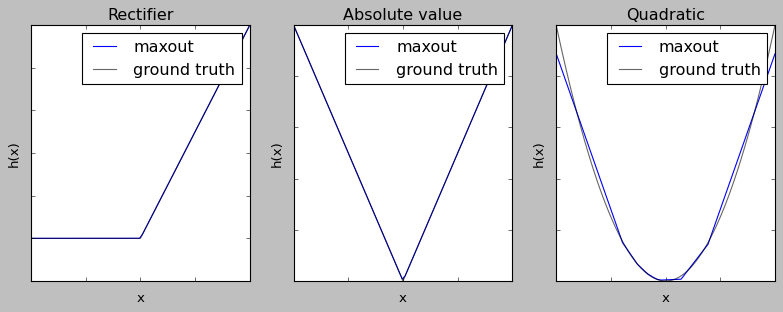

In [7]:
plt.style.use('classic')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

ax = ax.flatten() # make indexing way easier
for i, (func, y_hat) in enumerate(y_pred.items()):
    ax[i].plot(X_train, y_hat, label='maxout', color='blue')
    ax[i].plot(X_train, y_train[func], label='ground truth', alpha=0.6, color='black')
    ax[i].set_title(f'{func}')
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('h(x)')
    ax[i].set_xticklabels([]) 
    ax[i].set_yticklabels([])
    ax[i].legend()
plt.show()